In [1]:
pip install --force-reinstall agent_system/dist/mesa_restaurant_agents-0.0.1-py3-none-any.whl

Processing c:\users\s.neumann\documents\11_master_cas\code\mesa-restaurant-agents\agent_system\dist\mesa_restaurant_agents-0.0.1-py3-none-any.whl
  Using cached mesa-3.1.0-py3-none-any.whl.metadata (9.9 kB)
  Using cached pandas-2.2.3-cp312-cp312-win_amd64.whl.metadata (19 kB)
  Using cached numpy-2.2.2-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached scikit_learn-1.6.1-cp312-cp312-win_amd64.whl.metadata (15 kB)
  Using cached scipy-1.15.1-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached matplotlib-3.10.0-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached plotly-5.24.1-py3-none-any.whl.metadata (7.3 kB)
  Using cached contourpy-1.3.1-cp312-cp312-win_amd64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.56.0-cp312-cp312-win_amd64.whl.metadata (103 kB)
  Using cached kiwisolver-1.4.8-cp312-cp312-win_amd64.whl.metadata (6.3 kB)
  Using 

In [3]:
import mesa
from mesa_restaurant_agents.model.restaurant_model import RestaurantModel

params = {"n_waiters":2, "grid_width":20, "grid_height": 20}

results = mesa.batch_run(
    RestaurantModel,
    parameters=params,
    iterations=1,
    max_steps=15,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)
print(results)

SyntaxError: invalid decimal literal (restaurant_model.py, line 7)

In [3]:
from mesa_restaurant_agents.model.restaurant_model import RestaurantModel

model = RestaurantModel(n_waiters=2, grid_width=23, grid_height=23)
for i in range(10):
    model.step()

TypeError: object of type 'NoneType' has no len()

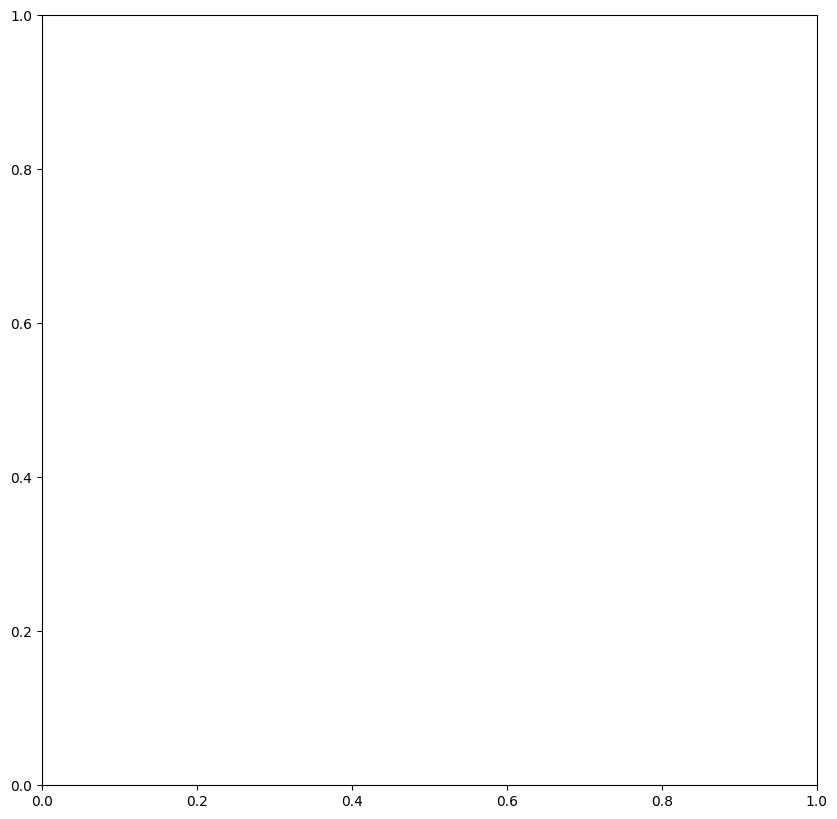

In [4]:
from mesa_restaurant_agents.visualization import *

ani = animate_first_run(results)
ani.save('animated_heatmap.gif', writer='pillow', fps=2, dpi=80)
df_mean_step = display_mean_step_results(results)
df_first_run_customer = display_first_run_step_results_customer(results)
df_first_run_waiter = display_first_run_step_results_waiter(results)

In [5]:
df_mean_step

,Step,mean_customer_count,mean_waiting_time,mean_customer_satisfaction,mean_profit
0,0,2.8,0.000000,100.000000,0.0
1,1,5.0,0.000000,100.000000,0.0
2,2,6.4,2.330952,95.338095,0.0
3,3,8.0,5.109812,89.780375,0.0
4,4,10.2,7.007071,85.985859,0.0
5,5,12.6,8.928467,82.143065,0.0
6,6,15.2,11.240132,77.519735,0.0
7,7,17.4,13.448270,73.103460,0.0
8,8,18.4,16.639881,66.720238,0.0
9,9,20.0,19.425618,61.148764,0.0


In [6]:
df_first_run_customer.sort_values(['customer_nr', 'step'])

,customer_nr,waiting_time,order_status,satisfaction,step
0,4,0.0,1,100.0,0
5,4,0.0,1,100.0,1
11,4,5.0,1,90.0,2
18,4,10.0,1,80.0,3
25,4,15.0,1,70.0,4
...,...,...,...,...,...
99,19,0.0,1,100.0,9
116,19,0.0,1,100.0,10
100,20,0.0,1,100.0,9
117,20,0.0,1,100.0,10


In [7]:
df_first_run_waiter.sort_values(['waiter_nr', 'step'])

,waiter_nr,tips,avg_rating,served_customers,step
0,1,0,0,0,0
2,1,0,0,0,1
4,1,0,0,0,2
6,1,0,0,0,3
8,1,0,0,0,4
10,1,0,0,0,5
12,1,0,0,0,6
14,1,0,0,0,7
16,1,0,0,0,8
18,1,0,0,0,9
